## Red neuronal Perceptrón multicapa  



In [1]:
#%tensorflow_version 1.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
tf.__version__

'1.15.0'

## Lectura del conjunto de datos 

In [3]:
from tensorflow.keras.datasets.fashion_mnist import load_data
fashion_mnist = load_data()
#read_data_sets("exercice/data", one_hot = True)

## Separando el conjunto de datos en Entrenamiento y prueba 

In [4]:
(x_train, y_train), (x_test, y_test)=fashion_mnist


Analizando el conjunto de Fashion_mnist

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
imagendemo=x_train[0,:,:]

In [7]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.reshape([-1,1]))
y_test = onehot_encoder.fit_transform(y_test.reshape([-1,1]))

In [8]:
x_train=x_train.reshape([-1,28*28]).astype('float')
y_train=y_train.astype('float')
x_test=x_test.reshape([-1,28*28]).astype('float')
y_test=y_test.astype('float')

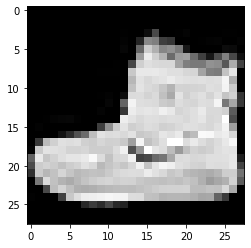

In [9]:
plt.imshow(imagendemo,cmap='gray')

Las etiquetas numéricas pueden ser transformadas al nombre de la clase correspondiente usando el siguiente diccionario 

In [10]:
label_dict = {
 0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"
}

In [11]:
label_dict

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [12]:
def Neural_network_model(
    n_nodes_hl1=500,
    n_nodes_hl2=500,
    n_nodes_hl3=500,
    n_classes=10
    ):
    # Declarando las entradas y salidas
    x=tf.placeholder('float',[None,784])
    y=tf.placeholder('float')
    
    # Declarando las variables 
    
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([784, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    
    # Declarando la arquitectura
    
    l1 = tf.add(tf.matmul(x,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']
    
    # Declarando la funcion de costo y optimizador
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=output
                                                                   , labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    return dict(
              x=x,
              y=y,
              output=output,
              cost=cost,
              optimizer=optimizer
              )

In [13]:

class batch_loader:
    def __init__(self,data_x,data_y,batch_size=100):
        self.x=data_x
        self.y=data_y
        self.index=0
        self.len=len(data_x)
        self.batch_size=batch_size
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.len

    def __next__(self):
        if self.index+self.batch_size<=self.len:
            to_return=(self.x[self.index:self.index+self.batch_size,:],self.y[self.index:self.index+self.batch_size,:])
            self.index+=self.batch_size
            return to_return
        elif self.index<self.batch_size:
            to_return=(self.x[self.index:,:],self.y[self.index:,:])
            self.index=self.len
            return to_return
        else:
            raise StopIteration

In [14]:
def train_neural_network(DNN, x_train,y_train, x_test,y_test, hm_epochs=10,batch_size=100):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for epoch_x, epoch_y in batch_loader(x_train,y_train):
                feed_dict={DNN["x"]: epoch_x, 
                           DNN["y"]: epoch_y}
                _, c, prediction,y   = sess.run([DNN["optimizer"], DNN["cost"]
                                                 , DNN["output"], DNN["y"]], 
                                                feed_dict=feed_dict)
                epoch_loss += c
                
            #Prueba con datos de entrenamiento
            prediction,y   = sess.run([DNN["output"], DNN["y"]], feed_dict={DNN["x"]:x_train, DNN["y"]:y_train})
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            train_accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
            #Prueba con datos nunca antes vistos  
            prediction,y   = sess.run([DNN["output"], DNN["y"]], feed_dict={DNN["x"]:x_test, DNN["y"]:y_test})
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            test_accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
     
            template = 'Epoch {:02}/{}, Perdida: {:.2f}, Exactitud entrenamiento: {:.2f}, Exactitud de prueba: {:.2f}'
            print(template.format(epoch+1,hm_epochs,
                             epoch_loss,
                            train_accuracy.eval()*100,
                            test_accuracy.eval()*100))

In [15]:
DNN=Neural_network_model()
train_neural_network(DNN,x_train,y_train,x_test,y_test,hm_epochs=100)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 01/100, Perdida: 574281410.70, Exactitud entrenamiento: 80.10, Exactitud de prueba: 78.52
Epoch 02/100, Perdida: 206811110.70, Exactitud entrenamiento: 82.01, Exactitud de prueba: 79.13
Epoch 03/100, Perdida: 141395304.81, Exactitud entrenamiento: 84.08, Exactitud de prueba: 80.23
Epoch 04/100, Perdida: 106264510.88, Exactitud entrenamiento: 84.43, Exactitud de prueba: 80.34
Epoch 05/100, Perdida: 83992133.61, Exactitud entrenamiento: 85.58, Exactitud de prueba: 81.28
Epoch 06/100, Perdida: 69882070.14, Exactitud entrenamiento: 87.42, Exactitud de prueba: 82.21
Epoch 07/100, Perdida: 56621287.18, Exactitud entrenamiento: 87.08, Exactitud de prueba: 81.43
Epoch 08/100, Perdida: 48990442.58, Exactitud entrenamiento: 88.34, Exactitud de prueba: 82.42
Epoch 09/100, Perdida: 41356337.48, Exactitud